In [1]:
import os
from dotenv import load_dotenv
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter  
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
from tqdm import tqdm
load_dotenv()

c:\Users\Hp\anaconda3\envs\langgraph\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
PDF_PATH = "medical.pdf" 
CHROMA_DIR = os.getenv("CHROMA_DIR", "./chroma_store")
EMBED_MODEL = os.getenv("EMBED_MODEL", "sentence-transformers/all-MiniLM-L6-v2")

In [ ]:
def ingest_pdf():
    if not os.path.exists(PDF_PATH):
        raise FileNotFoundError(f"{PDF_PATH} not found. Place your medical PDF in the project folder.")

    print("[Ingest] Loading PDF...")
    loader = PyPDFLoader(PDF_PATH)
    docs = loader.load()

    print(f"[Ingest] Loaded {len(docs)} pages. Splitting into chunks...")
    splitter = RecursiveCharacterTextSplitter(chunk_size=800, chunk_overlap=150)
    chunks = splitter.split_documents(docs)

    print(f"[Ingest] Total chunks: {len(chunks)}")
    embeddings = HuggingFaceEmbeddings(model_name=EMBED_MODEL)

    print("[Ingest] Creating Chroma vector database...")
    vectordb = Chroma.from_documents(documents=chunks, embedding=embeddings, persist_directory=CHROMA_DIR)
    vectordb.persist()
    print(f"[Ingest] ✅ Ingestion complete. Data stored in: {CHROMA_DIR}")

if __name__ == "__main__":
    ingest_pdf()

[Ingest] Loading PDF...


In [3]:
import os, json
from typing import TypedDict, Any, List
from dotenv import load_dotenv
from groq import Groq
from langgraph.graph import StateGraph, END
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
load_dotenv()

True

In [4]:
class AgentState(TypedDict):
    question: str
    plan: dict
    retrieved_docs: list
    answer: str
    reflection: dict

In [5]:
def groq_call(system: str, user: str) -> str:
    client = Groq(api_key=os.getenv("GROQ_API_KEY"))
    model = "llama-3.3-70b-versatile"
    resp = client.chat.completions.create(
        model=model,
        messages=[{"role": "system", "content": system},
                  {"role": "user", "content": user}],
        temperature=0.2,
        max_tokens=512
    )
    return resp.choices[0].message.content.strip()

In [6]:
# --- Retrieval Setup ---
def get_retriever():
    embeddings = HuggingFaceEmbeddings(model_name=os.getenv("EMBED_MODEL", "sentence-transformers/all-MiniLM-L6-v2"))
    vectordb = Chroma(persist_directory=os.getenv("CHROMA_DIR", "./chroma_store"), embedding_function=embeddings)
    return vectordb.as_retriever(search_kwargs={"k": 3})

In [7]:
# --- Nodes ---
def plan_node(state: AgentState) -> AgentState:
    q = state["question"]
    plan = {"need_retrieval": len(q.split()) > 2, "query": q}
    print(f"[PLAN] {plan}")
    state["plan"] = plan
    return state


In [8]:
def retrieve_node(state: AgentState) -> AgentState:
    if not state["plan"]["need_retrieval"]:
        print("[RETRIEVE] Skipped retrieval")
        state["retrieved_docs"] = []
        return state

    retriever = get_retriever()
    docs = retriever.invoke(state["plan"]["query"])
    state["retrieved_docs"] = [{"content": d.page_content[:300]} for d in docs]
    print(f"[RETRIEVE] Retrieved {len(docs)} docs")
    return state

In [9]:
def answer_node(state: AgentState) -> AgentState:
    context = "\n".join([d["content"] for d in state.get("retrieved_docs", [])])
    question = state["question"]

    system = "You are a helpful medical assistant. Answer clearly using only provided context."
    user = f"Question: {question}\n\nContext:\n{context}\n\nAnswer:"
    answer = groq_call(system, user)
    print(f"[ANSWER] {answer[:120]}...")
    state["answer"] = answer
    return state

In [10]:
def reflect_node(state: AgentState) -> AgentState:
    question, answer = state["question"], state["answer"]
    system = "You are a strict evaluator. Score answer relevance (0–1)."
    user = f"Question: {question}\nAnswer: {answer}\nReturn JSON: {{'relevance':score,'comment':text}}"
    review = groq_call(system, user)
    try:
        reflection = json.loads(review)
    except:
        reflection = {"relevance": 0.7, "comment": review}
    print(f"[REFLECT] {reflection}")
    state["reflection"] = reflection
    return state

In [11]:
# --- LangGraph Build ---
def build_agent():
    graph = StateGraph(AgentState)
    graph.add_node("plan", plan_node)
    graph.add_node("retrieve", retrieve_node)
    graph.add_node("answer", answer_node)
    graph.add_node("reflect", reflect_node)

    graph.set_entry_point("plan")
    graph.add_edge("plan", "retrieve")
    graph.add_edge("retrieve", "answer")
    graph.add_edge("answer", "reflect")
    graph.add_edge("reflect", END)

    return graph.compile()

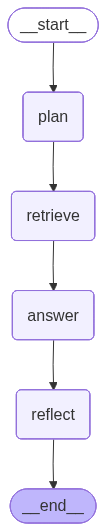

In [12]:
app=build_agent()
app

In [13]:
def run_agent(question: str) -> AgentState:
    app = build_agent()
    init: AgentState = {"question": question, "plan": {}, "retrieved_docs": [], "answer": "", "reflection": {}}
    final = app.invoke(init)
    return final

In [14]:
if __name__ == "__main__":
    result = run_agent("What are the symptoms of diabetes?")
    print("\n=== FINAL ANSWER ===")
    print(result["answer"])
    print("\n=== REFLECTION ===")
    print(result["reflection"])


[PLAN] {'need_retrieval': True, 'query': 'What are the symptoms of diabetes?'}


C:\Users\Hp\AppData\Local\Temp\ipykernel_14168\1227339322.py:3: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name=os.getenv("EMBED_MODEL", "sentence-transformers/all-MiniLM-L6-v2"))
C:\Users\Hp\AppData\Local\Temp\ipykernel_14168\1227339322.py:4: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the `langchain-chroma package and should be used instead. To use it run `pip install -U `langchain-chroma` and import as `from `langchain_chroma import Chroma``.
  vectordb = Chroma(persist_directory=os.getenv("CHROMA_DIR", "./chroma_store"), em

[RETRIEVE] Retrieved 3 docs
[ANSWER] The symptoms of diabetes include: 

1. High blood sugar (hyperglycemia)
2. Neurological problems, such as:
   - Weakness...
[REFLECT] {'relevance': 0.7, 'comment': "{'relevance':0.6,'comment':'The answer provides some symptoms of diabetes, but it is incomplete and partially inaccurate. Common symptoms of diabetes include increased thirst and hunger, frequent urination, fatigue, and slow healing of cuts and wounds. The answer also includes some symptoms that are not directly related to diabetes, such as loss of fine motor skills and loss of the sense of taste. A more comprehensive and accurate list of symptoms would be more relevant.'}"}

=== FINAL ANSWER ===
The symptoms of diabetes include: 

1. High blood sugar (hyperglycemia)
2. Neurological problems, such as:
   - Weakness
   - Lack of coordination
   - Blurred vision
   - Loss of fine motor skills
   - Loss of the sense of taste
   - Ringing in the ears
   - Loss of bladder control 

Note: Thes